# Load

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use("/home/kjeong/.config/matplotlib/custom.mplstyle")

import dill
import numpy as np
import pandas as pd
from time import time
ntraj = 28*28*24
length = 1000
lag_ls = [100, 200, 400, 600, 800, 900]
lag=400

In [2]:
plt.style.use("/home/kjeong/.config/matplotlib/custom.mplstyle")
plt.rcParams["text.latex.preamble"] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{cmbright}'#\usepackage{sansmath}\sansmath
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.sans-serif"] = 'cmbright'

In [3]:
cvs_df = pd.read_pickle("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/cvs_df.pkl")
dim_arr = np.load("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/AB_arr/dim_arr.npy")
mon_arr = np.load("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/AB_arr/mon_arr.npy")
other_arr = np.load("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/AB_arr/other_arr.npy")

#b. Extra features by combining previously computed ones
phi_alpha = cvs_df.loc[:,'phi-alpha'].to_numpy()
phi_alpha_lb = np.average(phi_alpha[dim_arr])-180
phi_alpha[phi_alpha<phi_alpha_lb] = phi_alpha[phi_alpha<phi_alpha_lb]+360

phi_alpha_me = cvs_df.loc[:,'phi-alpha(me)'].to_numpy()
phi_alpha_me_lb = np.average(phi_alpha_me[dim_arr])-180
phi_alpha_me[phi_alpha_me<phi_alpha_me_lb] = phi_alpha_me[phi_alpha_me<phi_alpha_me_lb]+360

phi_beta = cvs_df.loc[:,'phi-beta(me)'].to_numpy()
phi_beta_lb = np.average(phi_beta[dim_arr])-180
phi_beta[phi_beta<phi_beta_lb] = phi_beta[phi_beta<phi_beta_lb]+360

cvs_df["native_all"] = cvs_df.loc[:, "native"] + cvs_df.loc[:, "semi-native"]
"""
key = 'phi-open'
plt.hist(cvs_df.loc[dim_arr, key], alpha=0.5, density=True)
plt.hist(cvs_df.loc[other_arr, key], alpha=0.5, density=True)
plt.hist(cvs_df.loc[mon_arr, key], alpha=0.2, density=True)
"""

"\nkey = 'phi-open'\nplt.hist(cvs_df.loc[dim_arr, key], alpha=0.5, density=True)\nplt.hist(cvs_df.loc[other_arr, key], alpha=0.5, density=True)\nplt.hist(cvs_df.loc[mon_arr, key], alpha=0.2, density=True)\n"

In [4]:
# Load US weight
P_beagle=f"/beagle3/dinner/kjeong"
us_path=f"{P_beagle}/insulin_backedup/NVT_US_ins/cvs"
psis=np.load(f'{us_path}/input_PMFdata/t_50/Psis50.npy')
z=np.load(f'{us_path}/input_PMFdata/t_50/Zs50.npy')

nwindow, nframe_us = psis.shape[:-1]
nwindow_ax = int(np.sqrt(nwindow))
ntraj_w=24
ntraj = nwindow*ntraj_w
weight_us_all = np.zeros((nwindow, nframe_us))# (window, nframe per each traj 1050 )
for i0 in range(nwindow):
    psi_sum = np.sum(psis[i0], axis=1)
    weight_us_all[i0] = z[i0]/(psi_sum*nframe_us)
#/project/dinner/kjeong/insulin/pipeline/step0_catdcd
weight_us = weight_us_all[:, 42:1050:42]

w_us = np.repeat(np.ravel(weight_us), length).reshape(ntraj, length)
w_us[:,-lag:]=0
w_us = w_us/np.sum(w_us)                

## 1 Correlation w/ q w/ 

In [5]:
workdir = "/project/dinner/kjeong/insulin/pipeline/step7_5ns"

# state_arr
# k_ls = [100, 200, 400, 600]
# k_ls_hk =[1000, 1500, 2000, 3000]
state_arr = np.load(f"{workdir}/step1_cvs_state/state_arr.npy")
state_arr_hk = np.load(f"{workdir}/step1_cvs_state/state_arr_hk.npy")

#Memory
with open(f"{workdir}/step3_lag_mem/output/qf_unq_mem.pkl", "rb") as f:
    qf_unq_mem = dill.load(f)
with open(f"{workdir}/step3_lag_mem/output/qf_unq_mem_hk.pkl", "rb") as f:
    qf_unq_mem_hk = dill.load(f)

In [6]:
#k=600, rn=0 
print(state_arr[3,0].shape)
#k=2000, rn=0 
print(state_arr_hk[2,0].shape)
#lag_ls = [100, 200, 400, 600, 800, 900] 
#k=600, rn=0, lag=400 (2ns), div=0
# mem0, mem1
print(qf_unq_mem[3][0, 2, [0,1]].shape)
#k=2000, rn=0, lag=400 (2ns), div=0
# mem0, mem1
print(qf_unq_mem_hk[2][0, 2, [0,1]].shape)

(18816000,)
(18816000,)
(2, 600)
(2, 2000)


In [7]:
# Add committor (k, mem) = (600, 0), (600, 1), (2000, 0), (2000, 1) on cvs_df to compute `smaple-wise` correlation
print(lag_ls.index(lag))
state_arrs = np.vstack([state_arr[3,0], state_arr_hk[2,0]])
#for k_tmp, st_arr, qf_unq in zip([600, 2000], state_arrs, [qf_unq_mem[3][0, lag_ls.index(lag), [0,1]], qf_unq_mem_hk[2][0, lag_ls.index(lag), [0,1]]]):
k_tmp, st_arr, qf_unq = 600, state_arr[3,0], qf_unq_mem[3][0, lag_ls.index(lag), [0,1]]
cvs_df["state"] = st_arr
st_uq, st_id, st_inv = np.unique(st_arr, return_index=True, return_inverse=True)
for i_mem, q_tmp in enumerate(qf_unq):
    arr = np.zeros(ntraj*length)
    for i_st, q_val in enumerate(q_tmp):
        arr[st_inv==i_st] = q_val
    cvs_df[f"q_k{k_tmp}_mem{i_mem}"] = arr

2


In [8]:
cvs_df.loc[:, 'phi-alpha(me)'].corr(cvs_df.loc[:, 'phi-beta(me)'])

0.6516676923146796

In [9]:
corr_dic = {}
for key in cvs_df.keys():
    corr=cvs_df.loc[:, 'q_k600_mem0'].corr(cvs_df.loc[:, key])
    corr_mem=cvs_df.loc[:, 'q_k600_mem1'].corr(cvs_df.loc[:, key])
    corr_dic[key] = corr_mem
#corr_key = np.array(list(corr_dic.keys()))[np.argsort(np.abs(list(corr_dic.values())))]

In [10]:
cvs_df.keys()

Index(['phi-alpha', 'phi-alpha(me)', 'phi-beta', 'phi-beta(me)',
       'phi-open(ch1)', 'phi-open(ch2)', 'r_com', 'theta', 'phi', 'Theta',
       'Phi', 'Psi', 'Nwater(Interface)', 'Shared Nwater(Interface)', 'R_com',
       'CrossContact(7A)', 'zip-Dist', 'phi-open', 'beta', 'alpha', 'gamma1',
       'gamma2', 'betac', 'alphac', 'gamma1c', 'gamma2c', 'zip-turn',
       'zip-term', 'All', 'native', 'semi-native', 'non-native', 'detach1',
       'detach2', 'Q_Bagchi', 'Hbond( 24-24' )', 'Hbond( 24-26' )',
       'Hbond( 26-24' )', 'Hbond( 26-26' )', 'Hbridge( 24-24' )',
       'Hbridge( 24-26' )', 'Hbridge( 26-24' )', 'Hbridge( 26-26' )',
       'native_all', 'state', 'q_k600_mem0', 'q_k600_mem1'],
      dtype='object')

In [11]:
latex_lab = {
    "phi-alpha": r"$\tilde\Phi_\alpha$",
    "phi-alpha(me)": r"$\Phi_\alpha$",
    "phi-beta": r"$\tilde\Phi_\beta$",
    "phi-beta(me)": r"$\Phi_\beta$",
    "phi-open": r"$\bar\gamma$",
    "zip-Dist": r"$d_{\rm zip}$",
    "R_com": r"$R_{\rm com}$",
    "Q_Bagchi": r"$Q$",

    "All": r"$N_{\rm c}$",
    "native_all": r"$N_{\rm nat}$",
    #"semi-native": r"$N_{\rm natL}$",
    "non-native": r"$N_{\rm non}$",

    "Nwater(Interface)": r"$N_{\rm w}$",
    "Shared Nwater(Interface)": r"$N_{\rm {sw}}$",
    
    "beta": r"$\bar\beta$",
    "alpha": r"$\bar\alpha$",
    "gamma1": r"$\bar\gamma 2$",
    "gamma2": r"$\bar\gamma 1$",
    "betac": r"$\bar\beta_{c}$",
    "alphac": r"$\bar\alpha_{c}$",
    "gammac": r"$\bar\gamma_{c}$",
    "gamma1c": r"$\bar\gamma1_{c}$",
    "gamma2c": r"$\bar\gamma2_{c}$",

    "pmf": r"$\Delta G$",
    "qf": r"$q_{B}$",
}

In [12]:
key_ls = [ "Q_Bagchi", "R_com", 
            "betac", "beta", 
            "alphac","alpha",
            "All", "Nwater(Interface)", "Shared Nwater(Interface)",
            "phi-alpha(me)", "phi-beta(me)", "phi-open", "zip-Dist"
            ]
key_ls = key_ls[::-1]

<BarContainer object of 13 artists>

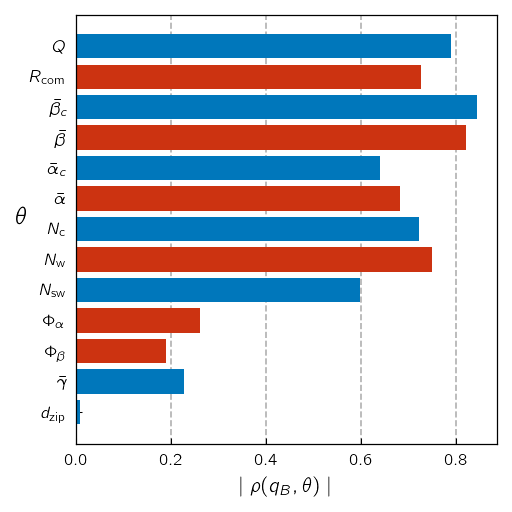

In [13]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize = (3.3, 3.3), constrained_layout=True, sharey=True, sharex=True)

ax.set_xlabel(r"$\mid\rho(q_B, \theta)\mid$", fontsize=10)
ax.set_ylabel(r"$\theta$", rotation=0, fontsize=12)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.grid(axis='x', linestyle='--', zorder=0)
bar_length = []
bar_color = []
for key in key_ls:
    bar_length.append(np.abs(corr_dic[key]))
    bar_color.append('#CC3311' if corr_dic[key]>0 else '#0077BB')
ax.barh([latex_lab[key] for key in key_ls], bar_length, color=bar_color, zorder=2)

#plt.savefig(f"{workdir}/figure/step5_corr_cm.pdf")

(array([9778358., 2443973., 1168201., 1056208.,  953459., 1129761.,
         862548.,  403967.,  399249.,  591562.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

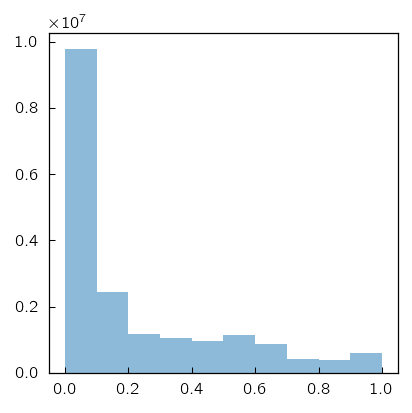

In [24]:
plt.hist(cvs_df.loc[:, "q_k600_mem1"], alpha=0.5, range=(0,1))

# 2. pmf

In [14]:
avg_df = pd.DataFrame({
        "q_k600_mem0": qf_unq_mem[3][0, lag_ls.index(lag), 0],
        "q_k600_mem1": qf_unq_mem[3][0, lag_ls.index(lag), 1],
        })

w_tmp = np.zeros(k_tmp)
key_ls = list(cvs_df.keys())
cvs_tmp = np.zeros((k_tmp, len(key_ls)))
for i_st in range(k_tmp):
    w_tmp[i_st] = np.ravel(w_us)[st_inv==i_st].sum()
    cvs_tmp[i_st] = cvs_df.loc[st_inv==i_st].mean().to_numpy()
avg_df['w_us'] = w_tmp
for i_key, key in enumerate(key_ls):
    avg_df[key] = cvs_tmp[:, i_key]

In [15]:
import scipy.constants as scicon
kbT_kJ=scicon.gas_constant*303.15*1e-3 #kJ/mol
kbT_kcal=scicon.gas_constant*303.15*1e-3/4.184 #kcal/mol
def P2pmf(arr):
    #Maximum probability is set to one (1)
    #Minimum pmf is set to zero
    return -kbT_kcal*np.log(arr/np.max(arr))
#is_range = [0.05, 0.15]
is_range = [0.12, 0.16]
ts_range = [0.48, 0.52]

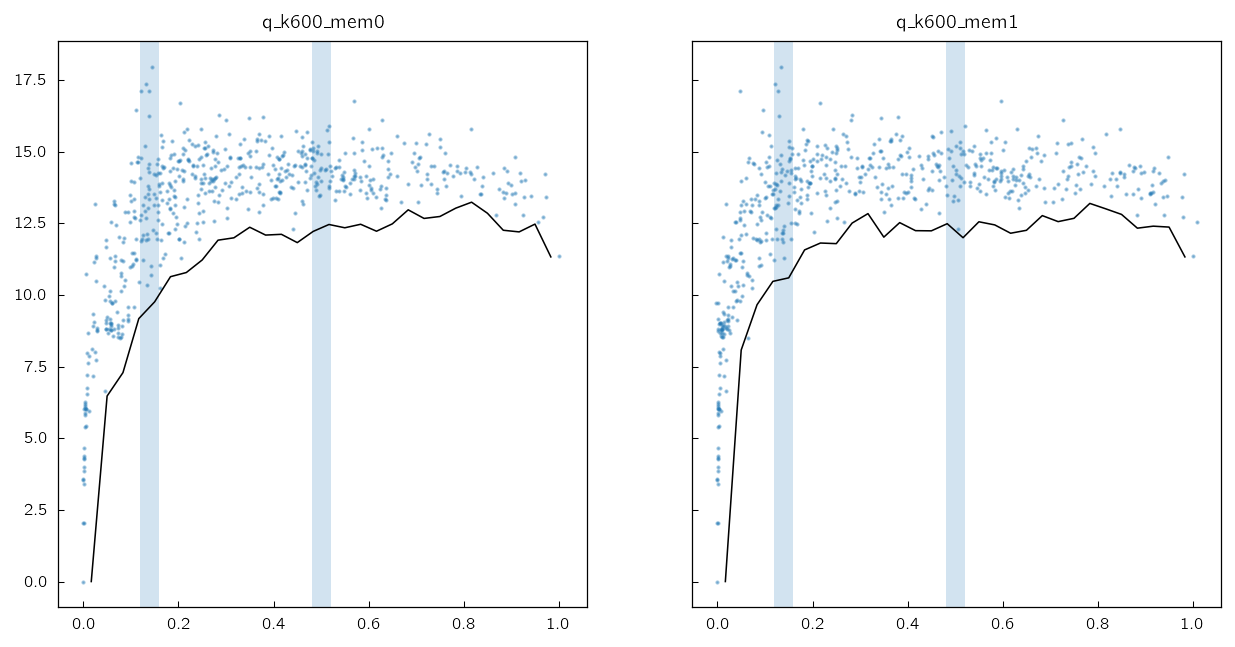

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

qbin = np.linspace(0, 1, 31)
x_tmp =(qbin[1:]+qbin[:-1])/2

for ic, key in enumerate(['q_k600_mem0', 'q_k600_mem1']):
    ax = axs[ic]
    ax.plot(avg_df.loc[:, key], P2pmf(avg_df.loc[:, "w_us"]), '.', alpha=0.4)
    ax.plot(x_tmp, P2pmf(np.histogram(avg_df[key], bins=qbin, weights=avg_df['w_us'])[0]), "k")
    ax.axvspan(*is_range, alpha=0.2)
    ax.axvspan(*ts_range, alpha=0.2)
    ax.set_title(f"{key}")


In [17]:
q_key = "q_k600_mem1" #"qf"

mask_avg_is = (avg_df.loc[:, q_key]>is_range[0]) & (avg_df.loc[:, q_key]<is_range[1])
mask_avg_ts = (avg_df.loc[:, q_key]>ts_range[0]) & (avg_df.loc[:, q_key]<ts_range[1])
mask_cvs_is = (cvs_df.loc[:, q_key]>is_range[0]) & (cvs_df.loc[:, q_key]<is_range[1])
mask_cvs_ts = (cvs_df.loc[:, q_key]>ts_range[0]) & (cvs_df.loc[:, q_key]<ts_range[1])

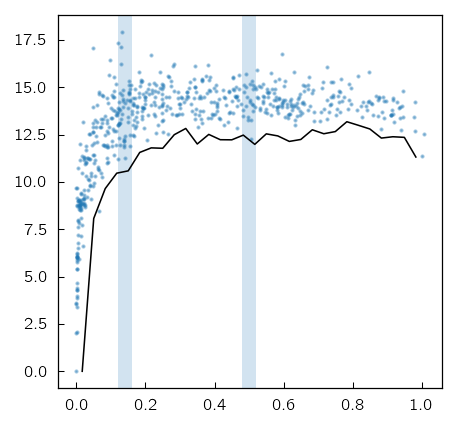

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3.3))

qbin = np.linspace(0, 1, 31)
x_tmp =(qbin[1:]+qbin[:-1])/2

ax.plot(avg_df.loc[:, q_key], P2pmf(avg_df.loc[:, "w_us"]), '.', alpha=0.4)
ax.plot(x_tmp, P2pmf(np.histogram(avg_df[q_key], bins=qbin, weights=avg_df['w_us'])[0]), "k")
ax.axvspan(*is_range, alpha=0.2)
ax.axvspan(*ts_range, alpha=0.2)

# 4. 2D projection

In [19]:
import sys
sys.path.append("/project/dinner/kjeong/insulin/notebooks/pylocal")
from utils_rwdga import projs2d
def center(arr):
    return (arr[1:]+arr[:-1])/2

In [20]:
np.min(cvs_df['R_com']), np.max(cvs_df['R_com'])

(1.5113762067956396, 6.597048056392022)

In [21]:
np.max(cvs_df['Q_Bagchi'])

68.37281536332479

In [24]:
avg_df.keys()

Index(['q_k600_mem0', 'q_k600_mem1', 'w_us', 'phi-alpha', 'phi-alpha(me)',
       'phi-beta', 'phi-beta(me)', 'phi-open(ch1)', 'phi-open(ch2)', 'r_com',
       'theta', 'phi', 'Theta', 'Phi', 'Psi', 'Nwater(Interface)',
       'Shared Nwater(Interface)', 'R_com', 'CrossContact(7A)', 'zip-Dist',
       'phi-open', 'beta', 'alpha', 'gamma1', 'gamma2', 'betac', 'alphac',
       'gamma1c', 'gamma2c', 'zip-turn', 'zip-term', 'All', 'native',
       'semi-native', 'non-native', 'detach1', 'detach2', 'Q_Bagchi',
       'Hbond( 24-24' )', 'Hbond( 24-26' )', 'Hbond( 26-24' )',
       'Hbond( 26-26' )', 'Hbridge( 24-24' )', 'Hbridge( 24-26' )',
       'Hbridge( 26-24' )', 'Hbridge( 26-26' )', 'native_all', 'state'],
      dtype='object')

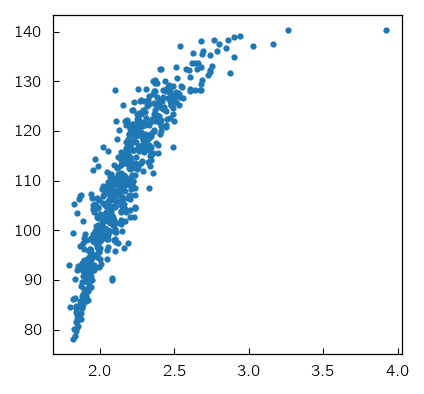

In [26]:
plt.scatter(*avg_df.loc[:, ['R_com', 'Nwater(Interface)']].to_numpy().T)

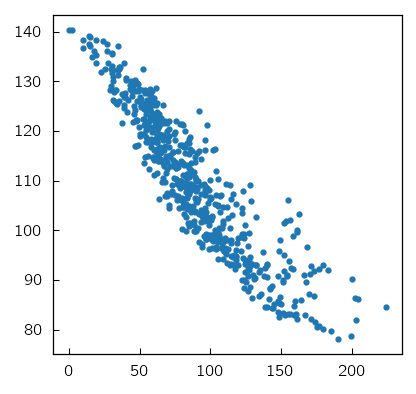

In [27]:
plt.scatter(*avg_df.loc[:, ['All', 'Nwater(Interface)']].to_numpy().T)

In [33]:
import extq2
args = [
    cvs_df.loc[:, q_key].to_numpy().reshape((ntraj, length)),
    1-cvs_df.loc[:, q_key].to_numpy().reshape((ntraj, length)),
    w_us,
    other_arr.reshape((ntraj, length))
]

dt=2e-15
log=2500

cv_pairs = [
    ('beta', 'alpha', [0.4, 3.0], [0.5, 3.0]),
    ('betac', 'alphac', [0.0, 1.0], [0.0, 1.0]),
    ("beta", "phi-beta", [0.4, 3.0], [-180, 180]),
    ("beta", "phi-alpha", [0.4, 3.0], [phi_alpha_lb, phi_alpha_lb+360]),
    ("alpha", "phi-beta", [0.5, 3.0], [-180, 180]),
    ("alpha", "phi-alpha", [0.5, 3.0], [phi_alpha_lb, phi_alpha_lb+360]),
    ("R_com", "Q_Bagchi", [1.5, 5], [0, 70]),
]

cv_ls_unq = [[lab_tmp1, lab_tmp2] for lab_tmp1, lab_tmp2, _, _ in cv_pairs]
cv_ls_unq = np.unique(np.array(cv_ls_unq))
t0=time()

In [34]:
for cv_tmp in cv_ls_unq:
    if cv_tmp in cvs_df.keys():
        cvs_df["j_us_"+cv_tmp] = np.ravel(np.vstack(extq2.tpt.current(*args, cvs_df.loc[:, cv_tmp].to_numpy().reshape((ntraj, length)), lag))/(dt*log))
print(f"{time()-t0}")

150.55861639976501


In [35]:
#Histogram: pj_insts, pj_insts_J
t0=time()
resol=51
pj_insts={}

resol_J = 11
kde_sigma_J=0.4
pj_insts_J={}
for pairs in cv_pairs:
    xstr, ystr, xlim, ylim = pairs
    xtj = cvs_df.loc[:, xstr].to_numpy()
    ytj = cvs_df.loc[:, ystr].to_numpy()
    pj_tmp, pj_J_tmp = [
        projs2d(xtj, ytj, 
                np.linspace(xlim[0], xlim[1], resol_tmp), 
                np.linspace(ylim[0], ylim[1], resol_tmp), 
                xstr, ystr, lag, ntraj, length) for resol_tmp in [resol, resol_J]
    ]
    for data_str in ["w_us", q_key]:
        if data_str[0]=='w':
            pj_tmp.calc(data_str, weights=np.ravel(w_us), kde_sigma=None)
            arr_tmp = pj_tmp.proj[data_str]
            pj_tmp.proj["pmf"+data_str[1:]]=np.zeros(arr_tmp.shape)
            pj_tmp.proj["pmf"+data_str[1:]][arr_tmp<=0] = np.nan
            pj_tmp.proj["pmf"+data_str[1:]][arr_tmp>0] = P2pmf(arr_tmp[arr_tmp>0])
        else:
            pj_tmp.calc(data_str, weights=np.ravel(w_us), func=cvs_df.loc[:, q_key].to_numpy())
    pj_insts[(xstr, ystr)]=pj_tmp
    
    for data_str in ["j_us_"+xstr, "j_us_"+ystr]:
        w_tmp = cvs_df.loc[:, data_str].to_numpy()    
        pj_J_tmp.calc(data_str, weights=w_tmp, kde_sigma=kde_sigma_J)
    pj_insts_J[(xstr, ystr)]=pj_J_tmp
print(f"{time()-t0}")

38.809208393096924


In [36]:
# define some colormaps
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [92]:
latex_lab = {
    "phi-alpha": r"$\tilde\Phi_\alpha\ (^\circ)$",
    "phi-alpha(me)": r"$\Phi_\alpha\ (^\circ)$",
    "phi-beta": r"$\tilde\Phi_\beta\ (^\circ)$",
    "phi-beta(me)": r"$\Phi_\beta\ (^\circ)$",
    "phi-open": r"$\bar\gamma\ (^\circ)$",
    "zip-Dist": r"$d_{\rm zip}\ {\rm (nm)}$",
    "R_com": r"$R_{\rm com}\ {\rm (nm)}$",
    "Q_Bagchi": r"$Q$",

    "All": r"$N_{\rm c}$",
    "native_all": r"$N_{\rm nat}$",
    #"semi-native": r"$N_{\rm natL}$",
    "non-native": r"$N_{\rm non}$",

    "Nwater(Interface)": r"$N_{\rm w}$",
    "Shared Nwater(Interface)": r"$N_{\rm {sw}}$",
    
    "beta": r"$\bar\beta\ {\rm (nm)}$",
    "alpha": r"$\bar\alpha\ {\rm (nm)}$",
    "gamma1": r"$\bar\gamma 2$",
    "gamma2": r"$\bar\gamma 1$",
    "betac": r"$\bar\beta_{c}$",
    "alphac": r"$\bar\alpha_{c}$",
    "gammac": r"$\bar\gamma_{c}$",
    "gamma1c": r"$\bar\gamma1_{c}$",
    "gamma2c": r"$\bar\gamma2_{c}$",

    "pmf": r"$\Delta G\ {\rm (kcal/mol)}$",
    "qf": r"$q_{B}$",
}

0.1352837085723877


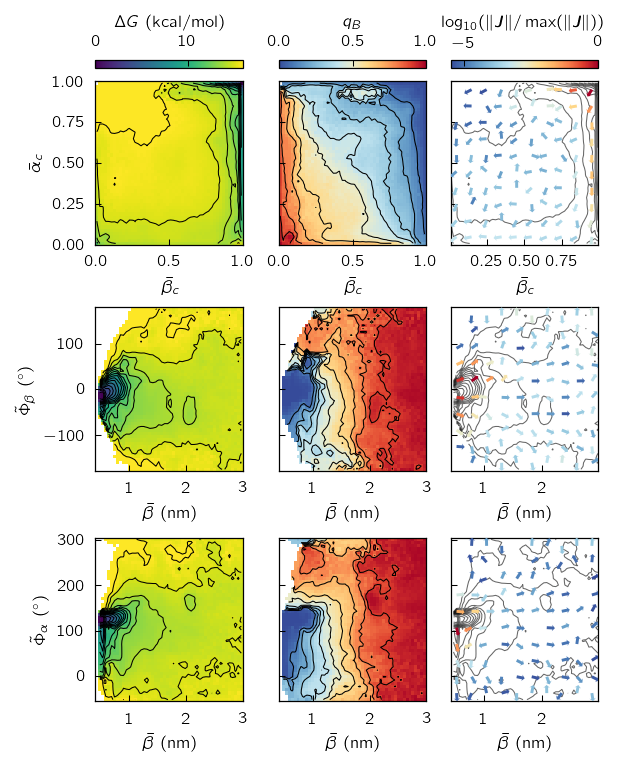

In [103]:
#Plot
t0=time()
plot_quant_dic = {
    "pmf_us": (np.arange(1, 17, 1), None, r"$\Delta G $\ (kcal/mol)"),
    q_key: (np.linspace(0, 1, 11), cm_div, r"$q_{B}$"),
    "stdev: qf": (np.linspace(0, 0.25, 11), cm_div, r"$\Delta q_B$"),
    "current": (np.arange(1, 17, 1), None, r"$\log_{10}(\Vert\mathbold{J}\Vert/\max(\Vert \mathbold{J}\Vert))$"),
    #"IS": (np.arange(1, 17, 1), None, None),
    #"TS": (np.arange(1, 17, 1), None, None),
                 }

fig_type = 'si1' #'si'
fig_width = 4.0
if fig_type == 'main':
    cv_pairs_tmp = [cv_pairs[0]]
    fig_width = 7.25
    lw = 1.
elif fig_type == 'si1':
    cv_pairs_tmp = cv_pairs[1:4]
    lw = 0.5
elif fig_type == 'si2':
    cv_pairs_tmp = [cv_pairs[-1]] + cv_pairs[4:-1]
    lw = 0.5

nrow, ncol = len(cv_pairs_tmp), 3
fig_height = nrow*fig_width/ncol +1

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height), constrained_layout=True, sharey='row')
axs = axs.reshape(nrow, ncol)

arrow_cutoff = -5.5
for ir, pairs in enumerate(cv_pairs_tmp):
    for ic, key in enumerate(["pmf_us", q_key, "current"]):
        if key == 'current':
            quant_str = 'pmf_us'
        else:
            quant_str = key
        clines, cmap, cb_tmp = plot_quant_dic[key]
        ax = axs[ir, ic]
        xstr, ystr, _, _ = pairs
        pj_tmp, pj_J_tmp = pj_insts[(xstr, ystr)], pj_insts_J[(xstr, ystr)]
        ax.set_xlabel(latex_lab[xstr])
        if ic==0:
            ax.set_ylabel(latex_lab[ystr])

        clines_cont = np.arange(1, 17, 1) if quant_str == "pmf_us" else clines
        #if 
        alpha = 0.6 if ic==2 else 1
        ax.contour(center(pj_tmp.xlim), center(pj_tmp.ylim), pj_tmp.proj[quant_str].T, 
                   clines_cont, colors='k', alpha=alpha, linewidths=lw, zorder=20)

        if ic < 2:
            pc=ax.pcolormesh(pj_tmp.xlim, pj_tmp.ylim, pj_tmp.proj[key].T, 
                             vmin=0, vmax=clines[-1], cmap=cmap, rasterized=True, 
                             alpha=1, zorder=0)
        
        elif ic == 2:
            #Arrow
            X, Y = np.meshgrid(center(pj_J_tmp.xlim), center(pj_J_tmp.ylim))
            xarrow, yarrow = pj_J_tmp.proj["j_us_"+xstr], pj_J_tmp.proj["j_us_"+ystr]
            abs_arrow = np.sqrt(xarrow**2+yarrow**2)
            abs_arrow = abs_arrow/np.max(abs_arrow)
            #vmax, vmin = pair_Jminmax[ir]
            i_idx, j_idx = np.nonzero(np.log10(abs_arrow) > arrow_cutoff)#vmin
            quiv = ax.quiver(X[j_idx, i_idx], Y[j_idx, i_idx], 
                                        (xarrow/abs_arrow)[i_idx, j_idx], (yarrow/abs_arrow)[i_idx, j_idx],
                                        np.log10(abs_arrow[i_idx, j_idx]),
                                        angles = 'xy',
                                        clim=[arrow_cutoff, 0],
                                        cmap=cm_div,#"binary",#
                                        width=0.02,
                                        headwidth=2.2,
                                        headlength=1,
                                        headaxislength=.8,
                                        scale_units='inches',
                                        zorder=40,
                                        alpha=1
                                       )            
        if ir==0:
            cb_pc = pc if key != "current" else quiv
            cb = plt.colorbar(cb_pc, ax=ax, location='top')
            cb.set_label(label=cb_tmp)

print(f"{time()-t0}")    

#plt.savefig(f"{workdir}/figure/step5_proj_{fig_type}_cm.pdf", dpi=360)